# Plant Disease Detection with Plant Village and PlantDoc
## Import Libraries and configure directories

In [1]:
import os
import shutil
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plant_village_dir = "/kaggle/input/plantvillage-dataset/color"
plant_doc_dir = "/kaggle/input/plantdoc-dataset/train"
dataset_dir = "/kaggle/working/dataset/"

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

batch_size = 16

In [3]:
from tensorflow.keras.applications import ResNet50
# Load pre-trained ResNet-50 model without the top (fully connected) layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained ResNet-50 layers
for layer in resnet_base.layers:
    layer.trainable = True

# Create the rest of your model
model = keras.Sequential([
    keras.layers.Rescaling(scale=1/255, input_shape=(224, 224, 3)),
    
    resnet_base,
    
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(38, activation='sigmoid')
])

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                         

### Optimizer (optimizer='adam'):
   - An optimizer is a critical component of the training process in neural networks. It defines the specific algorithm used to adjust the model's parameters (weights and biases) during training in order to minimize the chosen loss function.
   - 'Adam' stands for Adaptive Moment Estimation, and it is a popular optimization algorithm. It combines the benefits of both the Adagrad and RMSprop optimizers. Adam adjusts the learning rates for each parameter individually and maintains moving averages of the gradients.
   - The optimizer's role is to update the model's weights in a way that helps it converge to a solution that minimizes the loss function.

### Loss Function (loss='sparse_categorical_crossentropy')
   - The loss function, also known as the cost function or objective function, measures the difference between the predicted values and the actual target values during training.
   - 'Sparse Categorical Crossentropy' is a loss function commonly used in classification tasks, particularly when dealing with integer-encoded class labels. It calculates the cross-entropy between the predicted probability distribution (after applying a softmax activation) and the true class labels.
   - In this case, 'sparse' indicates that the class labels are integer values (e.g., 0, 1, 2) rather than one-hot encoded vectors.

### 3. Metrics (metrics='accuracy'):
   - Metrics are used to evaluate and monitor the performance of the model during training and testing.
   - 'Accuracy' is a commonly used metric for classification problems. It measures the proportion of correctly predicted samples to the total number of samples. In a multi-class classification task, accuracy calculates the ratio of correctly classified samples to the total number of samples.

In [4]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])


Early stopping is a technique used during the training of neural networks to prevent overfitting and improve model generalization. It is based on a simple principle: if the model's performance on a validation dataset does not improve or worsens over a certain number of training epochs, training is halted to prevent the model from fitting the training data too closely. Let's explain the key components and the function of early stopping from first principles:

1. **Monitor ('val_loss')**:
   - The 'monitor' parameter specifies the metric that the early stopping algorithm should monitor to determine when to stop training. In this case, 'val_loss' is used, which means the validation loss is monitored. The validation loss is a measure of how well the model is performing on a separate validation dataset.

2. **Patience (patience=5)**:
   - The 'patience' parameter defines the number of epochs with no improvement in the monitored metric to wait before stopping the training process. If, for a specified number of consecutive epochs (in this case, 5), the validation loss doesn't decrease or improve, training is stopped. This is a mechanism to prevent the model from overfitting because further training might lead to worse generalization.

3. **Restore Best Weights (restore_best_weights=True)**:
   - When 'restore_best_weights' is set to 'True,' the early stopping callback will restore the model's weights to the best-performing state observed during training. This is essential because, during training, the model's weights might change in a way that leads to overfitting, but the best weights represent the model with the highest performance on the validation data. Restoring the best weights ensures that the model retains the best generalization ability.

To understand the function of early stopping, consider the training process:

- The model's performance on the validation dataset is continuously monitored.
- If, for the specified number of consecutive epochs (patience), the validation loss does not improve or starts to degrade, the training process is stopped early.
- By stopping training at this point, the model is prevented from overfitting, which can occur if it continues to fit the training data noise.

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can use other metrics like 'val_accuracy'
    patience=5,          # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore the best model weights when early stopping
)

## Train the model with PlantVillage Dataset
In this data-set, 38 different classes of 54305 plant leafs are available. 
The classes are,
1. Apple_scab
1. Apple_black_rot
1. Apple_cedar_apple_rust
1. Apple_healthy
1. Blueberry_healthy
1. Cherry_powdery_mildew
1. Cherry_healthy
1. Corn_gray_leaf_spot
1. Corn_common_rust
1. Corn_northern_leaf_blight
1. Corn_healthy
1. Grape_black_rot
1. Grape_black_measles
1. Grape_leaf_blight
1. Grape_healthy
1. Orange_haunglongbing
1. Peach_bacterial_spot
1. Peach_healthy
1. Pepper_bacterial_spot
1. Pepper_healthy
1. Potato_early_blight
1. Potato_healthy
1. Potato_late_blight
1. Raspberry_healthy
1. Soybean_healthy
1. Squash_powdery_mildew
1. Strawberry_healthy
1. Strawberry_leaf_scorch
1. Tomato_bacterial_spot
1. Tomato_early_blight
1. Tomato_healthy
1. Tomato_late_blight
1. Tomato_leaf_mold
1. Tomato_septoria_leaf_spot
1. Tomato_spider_mites_two-spotted_spider_mite
1. Tomato_target_spot
1. Tomato_mosaic_virus
1. Tomato_yellow_leaf_curl_virus

### Load the dataset

In [6]:
train_ds, test_ds = keras.utils.image_dataset_from_directory(
    plant_village_dir ,
    image_size=(224,224),
    batch_size=32,
    seed = 123,
    validation_split=.2,
    subset='both'
)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Using 10861 files for validation.


### Train the model

In [7]:
history = model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])

Epoch 1/50
1358/1358 [==============================] - 305s 188ms/step - loss: 1.2012 - accuracy: 0.6846 - val_loss: 0.3884 - val_accuracy: 0.8868
Epoch 2/50
1358/1358 [==============================] - 252s 186ms/step - loss: 0.3810 - accuracy: 0.8920 - val_loss: 1.5567 - val_accuracy: 0.6436
Epoch 3/50
1358/1358 [==============================] - 253s 186ms/step - loss: 0.2323 - accuracy: 0.9355 - val_loss: 0.1610 - val_accuracy: 0.9500
Epoch 4/50
1358/1358 [==============================] - 253s 186ms/step - loss: 0.1653 - accuracy: 0.9542 - val_loss: 0.2858 - val_accuracy: 0.9197
Epoch 5/50
1358/1358 [==============================] - 252s 186ms/step - loss: 0.1246 - accuracy: 0.9654 - val_loss: 0.4048 - val_accuracy: 0.8972
Epoch 6/50
1358/1358 [==============================] - 252s 185ms/step - loss: 0.0870 - accuracy: 0.9762 - val_loss: 0.2843 - val_accuracy: 0.9312
Epoch 7/50
1358/1358 [==============================] - 253s 186ms/step - loss: 0.0679 - accuracy: 0.9813 - val_

### Evaluation

In [8]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = [label for _, label in test_ds.unbatch()]
print(classification_report(true_labels, predicted_labels))

340/340 [==============================] - 20s 55ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       120
           1       1.00      0.99      1.00       124
           2       1.00      1.00      1.00        56
           3       1.00      1.00      1.00       348
           4       1.00      1.00      1.00       318
           5       1.00      1.00      1.00       208
           6       1.00      1.00      1.00       147
           7       0.94      0.93      0.94       109
           8       1.00      1.00      1.00       238
           9       0.96      0.96      0.96       200
          10       1.00      1.00      1.00       247
          11       1.00      1.00      1.00       229
          12       1.00      1.00      1.00       274
          13       1.00      1.00      1.00       219
          14       1.00      1.00      1.00        94
          15       1.00      1.00      1.00      1137
          16       1.00 

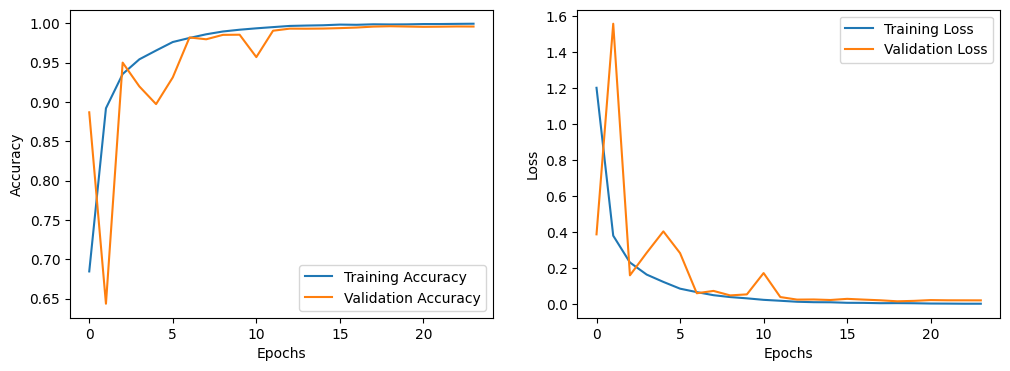

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Train the model with PlantVillage and PlantDoc Dataset

In [10]:
shutil.copytree(plant_village_dir, dataset_dir)

'/kaggle/working/dataset/'

### PlantDoc Dataset
PlantDoc has 27 classes of Plant Diseases.
1. Apple_Scab_Leaf
2. Apple_leaf
3. Apple_rust_leaf
4. Bell_pepper_leaf
5. Bell_pepper_leaf_spot
6. Blueberry_leaf
7. Cherry_leaf
8. Corn_Gray_leaf_spot
9. Corn_leaf_blight
10. Corn_rust_leaf
11. Peach_leaf
12. Potato_leaf_early_blight
13. Potato_leaf_late_blight
14. Raspberry_leaf
15. Soyabean_leaf
16. Squash_Powdery_mildew_leaf
17. Strawberry_leaf
18. Tomato_Early_blight_leaf
19. Tomato_Septoria_leaf_spot
20. Tomato_leaf
21. Tomato_leaf_bacterial_spot
22. Tomato_leaf_late_blight
23. Tomato_leaf_mosaic_virus
24. Tomato_leaf_yellow_virus
25. Tomato_mold_leaf
26. grape_leaf
27. grape_leaf_black_rot

### Merging PlantVillage with PlantDoc
I have merge the PlantVillage Dataset with PlantDoc with their respective classes as follows

In [11]:
class_mapping = {
    "Apple_Scab_Leaf": "Apple___Apple_scab",
    "Apple_leaf": "Apple___healthy",
    "Apple_rust_leaf": "Apple___Cedar_apple_rust",
    "Blueberry_leaf": "Blueberry___healthy",
    "Cherry_leaf": "Cherry_(including_sour)___healthy",
    "Corn_Gray_leaf_spot": "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_leaf_blight": "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_rust_leaf": "Corn_(maize)___Common_rust_",
    "Peach_leaf": "Peach___healthy",
    "Potato_leaf_early_blight": "Potato___Early_blight",
    "Potato_leaf_late_blight": "Potato___Late_blight",
    "Raspberry_leaf": "Raspberry___healthy",
    "Soyabean_leaf": "Soybean___healthy",
    "Squash_Powdery_mildew_leaf": "Squash___Powdery_mildew",
    "Strawberry_leaf": "Strawberry___healthy",
    "Tomato_Early_blight_leaf": "Tomato___Early_blight",
    "Tomato_Septoria_leaf_spot": "Tomato___Septoria_leaf_spot",
    "Tomato_leaf": "Tomato___healthy",
    "Tomato_leaf_bacterial_spot": "Tomato___Bacterial_spot",
    "Tomato_leaf_late_blight": "Tomato___Late_blight",
    "Tomato_leaf_mosaic_virus": "Tomato___Tomato_mosaic_virus",
    "Tomato_leaf_yellow_virus": "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato_mold_leaf": "Tomato___Leaf_Mold",
    "grape_leaf": "Grape___healthy",
    "grape_leaf_black_rot": "Grape___Black_rot"
}

In [12]:
for k, v in class_mapping.items():
    source_dir = f"/kaggle/input/plantdoc-dataset/train/{k}"
    dest_dir = f"/kaggle/working/dataset/{v}"
    file_list = os.listdir(source_dir)
    for filename in file_list:
        source_file = os.path.join(source_dir, filename)
        destination_file = os.path.join(dest_dir, filename)
        shutil.copy2(source_file, destination_file)

### Load the dataset

In [13]:
path = '/kaggle/working/dataset'
train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path ,
    image_size=(224,224),
    batch_size=32 ,
    seed = 123 ,
    validation_split=.2,
    subset='both'
)


Found 56530 files belonging to 38 classes.
Using 45224 files for training.
Using 11306 files for validation.


### Train the model

In [14]:
history = model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])

Epoch 1/50
1414/1414 [==============================] - 266s 188ms/step - loss: 0.2231 - accuracy: 0.9631 - val_loss: 0.1193 - val_accuracy: 0.9713
Epoch 2/50
1414/1414 [==============================] - 264s 187ms/step - loss: 0.1610 - accuracy: 0.9676 - val_loss: 0.1081 - val_accuracy: 0.9731
Epoch 3/50
1414/1414 [==============================] - 264s 186ms/step - loss: 0.1405 - accuracy: 0.9699 - val_loss: 0.1000 - val_accuracy: 0.9745
Epoch 4/50
1414/1414 [==============================] - 264s 187ms/step - loss: 0.1242 - accuracy: 0.9719 - val_loss: 0.0996 - val_accuracy: 0.9750
Epoch 5/50
1414/1414 [==============================] - 264s 187ms/step - loss: 0.1100 - accuracy: 0.9743 - val_loss: 0.0971 - val_accuracy: 0.9748
Epoch 6/50
1414/1414 [==============================] - 264s 186ms/step - loss: 0.1042 - accuracy: 0.9755 - val_loss: 0.0976 - val_accuracy: 0.9753
Epoch 7/50
1414/1414 [==============================] - 264s 186ms/step - loss: 0.0979 - accuracy: 0.9775 - val_

### Evaluation

In [15]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = [label for _, label in test_ds.unbatch()]
print(classification_report(true_labels, predicted_labels))

354/354 [==============================] - 20s 56ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       139
           1       0.99      1.00      1.00       117
           2       0.96      0.89      0.93        84
           3       0.96      0.98      0.97       364
           4       0.92      0.98      0.95       321
           5       1.00      1.00      1.00       211
           6       0.98      0.96      0.97       165
           7       0.88      0.95      0.92       125
           8       0.98      0.95      0.96       256
           9       0.94      0.94      0.94       244
          10       0.99      1.00      0.99       219
          11       0.99      0.97      0.98       268
          12       1.00      1.00      1.00       268
          13       1.00      1.00      1.00       221
          14       0.96      0.90      0.93       123
          15       1.00      1.00      1.00      1103
          16       1.00 

In [16]:
true_labels_one_hot = tf.one_hot(true_labels, depth=38)
predicted_labels_one_hot = tf.one_hot(predicted_labels, depth=38)
roc_auc = roc_auc_score(true_labels_one_hot, predicted_labels_one_hot, average='macro')
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9805547724762782


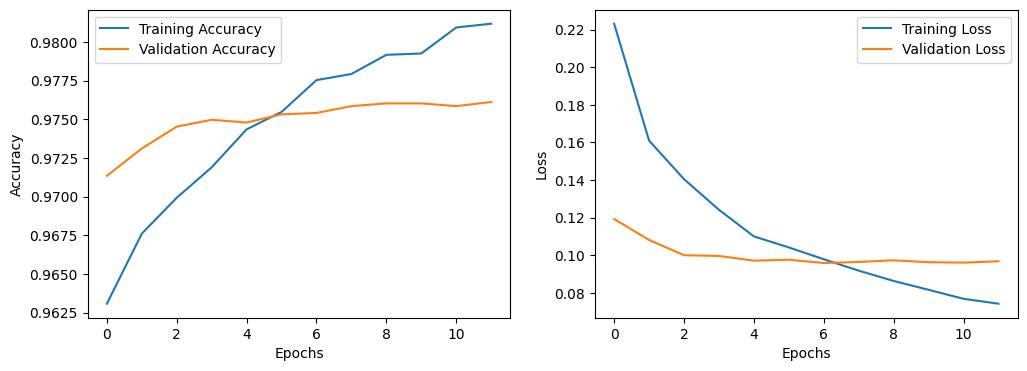

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Performance Comparison
This values from first version of the notebook. 

|   |Precision| Recall |F1 Score|Accuracy|No of Epoches|No of Samples|
|---|---|---|---|---|---|---|
| PlantVillage  |0.71|0.62|0.61|0.62|6|10861|
| PlantDoc train + Plant Village |0.86|0.85|0.85|0.85|18|11306|


## Further Enhancements Can be Done
### 1. Data Augmentation:
   Data augmentation is a technique in the field of machine learning and computer vision that can significantly enhance the quality and diversity of your dataset. It involves applying various transformations and modifications to your existing data, such as flipping, rotating, cropping, and introducing noise. This process generates additional training samples, reducing the risk of overfitting and improving the generalization capability of your model. Data augmentation can be particularly valuable in scenarios with limited labeled data, helping to create a more robust and comprehensive training set. By leveraging data augmentation, you can make your machine learning models more resilient and capable of handling variations and noise in real-world data.

### 2. Using Transfer Learning:
   Transfer learning is a powerful approach in deep learning where a pre-trained model, typically trained on a large dataset, is fine-tuned or used as a feature extractor for a different but related task. This technique offers several advantages, including faster convergence, better performance with limited data, and the ability to leverage the knowledge and features learned by the pre-trained model. By adopting transfer learning, you can save both time and computational resources in training deep neural networks from scratch. It is especially valuable when working with smaller datasets or when developing models for specific applications, as it allows you to harness the wisdom of models trained on extensive and diverse data sources. Overall, transfer learning is a practical strategy for improving the efficiency and effectiveness of deep learning models in various applications.